# Modeling

In this notebook I am apply different machine learning models to predict the skills that I need from the job descriptions.

## Table of contents

1. [Dataset loading and exploration](#Dataset-loading-and-preparation)
2. [Multi-class Classifiers](#Multi-class-Classifiers)

## Dataset loading and preparation

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import pandas as pd                # Data processing
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
%matplotlib inline
sns.set_theme()

In [3]:
df = pd.read_csv('noun_phrases_class.csv')
df['type'].value_counts()

not_skill     3459
hard_skill     468
soft_skill      73
Name: type, dtype: int64

As we can see the data set is not balanced. By far the most records describe the not_skill feature. Let's try some undersampling.

In [4]:
df_skills     = df[df['type'] != "not_skill"]
df_not_skills = df[df['type'] == "not_skill"].sample(n=500)

df = pd.concat([df_skills, df_not_skills], ignore_index=True)

<AxesSubplot: >

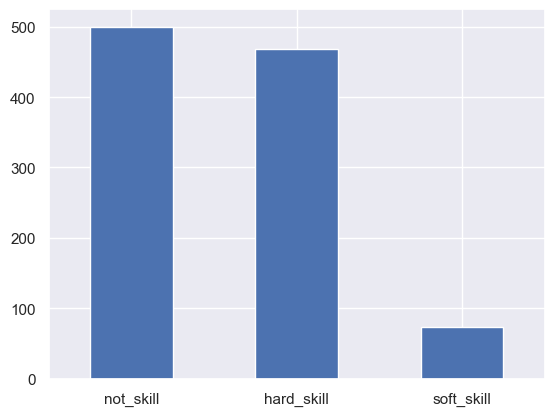

In [5]:
df['type'].value_counts().plot(kind='bar', rot=0)

In [6]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

#transformer = TfidfVectorizer(stop_words = 'english')
transformer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 3), stop_words='english')
X = transformer.fit_transform(df["phrase"])
np.shape(X)

(1041, 164)

In [7]:
from sklearn.model_selection import train_test_split

# Extract features and prediction vectors
y = df['type'].map({'not_skill':0, 'hard_skill':1, 'soft_skill':2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
X_train.shape, X_test.shape

((728, 164), (313, 164))

## Multi-class Classifiers

For this part I am going to train various classifiers and compare the training results. In detail the classifiers I will use are:

1. Multinomial Naive Bayes
2. Support Vector Machines (Both default and linear)
3. Random Forest
4. Logistic Regression

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

models = [
    MultinomialNB(),
    SVC(),
    LinearSVC(dual=False),
    RandomForestClassifier(random_state=0),
    LogisticRegression()
]

In [9]:
measurements = []

for model in models:
    model.fit(X_train, y_train)
    score_train = model.score(X_train, y_train)
    score_test  = model.score(X_test,  y_test)
    
    measurements.append([model.__class__.__name__, score_train, score_test])

In [10]:
results = pd.DataFrame(measurements, columns=['model', 'train_accuracy', 'test_accuracy'])
results

,model,train_accuracy,test_accuracy
0,MultinomialNB,0.813187,0.792332
1,SVC,0.881868,0.798722
2,LinearSVC,0.876374,0.789137
3,RandomForestClassifier,0.907967,0.792332
4,LogisticRegression,0.862637,0.808307


In [11]:
# Null Accuracy
class_choices = y_test.value_counts()

null_accuracy = class_choices[0] / sum(class_choices)

print('Null accuracy score: {0:0.4f}\n'.format(null_accuracy))

Null accuracy score: 0.4888



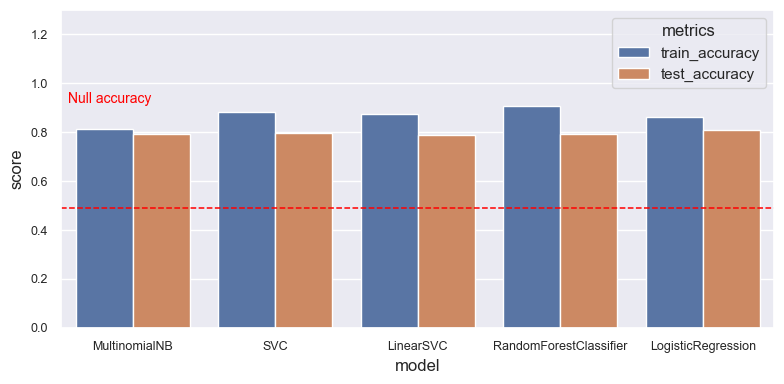

In [12]:
plt.figure(figsize=(8,4))

data_transformed = results.melt(id_vars='model', value_name='score', var_name='metrics')

metrics_plt = sns.barplot(data=data_transformed, x='model', y='score', hue='metrics')
metrics_plt.tick_params(labelsize=9)

plt.axhline(y=null_accuracy, ls='--', c='red', linewidth=1.1)
plt.text(-0.45, 0.92, "Null accuracy", c='red', size='small')
plt.ylim(0, 1.3)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import cross_val_score

# Get cross validated scores for input models
def get_cross_val_scores(models, x, y, cv=10):
    measurements = []
    for model in models:
        accuracies = cross_val_score(model, x, y, cv = cv, scoring = 'accuracy')

        for i, accuracy in enumerate(accuracies):
            measurements.append((model.__class__.__name__, i, accuracy))

    results = pd.DataFrame(measurements, columns=['model', 'fold', 'accuracy_score'])
    return results

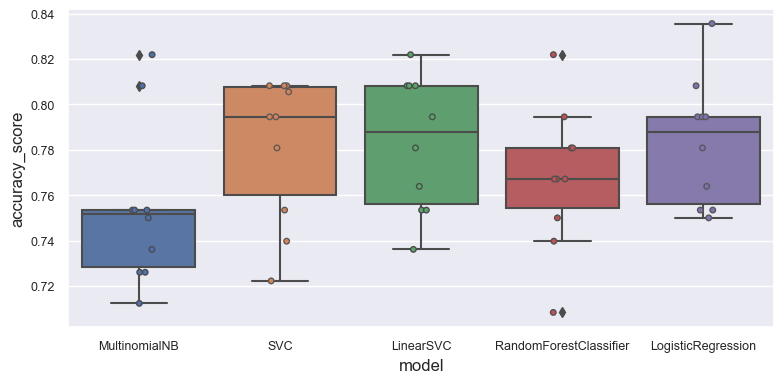

In [14]:
cv_results = get_cross_val_scores(models, X_train, y_train)

plt.figure(figsize=(8,4))

cs_metrics_bxplt = sns.boxplot(x='model', y='accuracy_score', data=cv_results)
cs_metrics_stplt = sns.stripplot(x='model', y='accuracy_score', hue='model', data=cv_results,
                                 size=4, jitter=True, linewidth=1, legend=False)

cs_metrics_bxplt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

In [15]:
cv_results.groupby('model').accuracy_score.mean()

model
LinearSVC                 0.782877
LogisticRegression        0.782896
MultinomialNB             0.754091
RandomForestClassifier    0.767751
SVC                       0.781545
Name: accuracy_score, dtype: float64

In [16]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter configurations for GridSearch
params_mnb = {'alpha': np.arange(0.01, 1, 0.01)}

params_svc = {'random_state': [0], 'C': np.arange(0.01, 1, 0.01), 'kernel':['rbf','linear'], 'gamma':['scale','auto'],
              'probability':[True,False], 'decision_function_shape':['ovo','ovr']}

params_lsv = {'random_state': [0], 'dual': [False], 'C': np.arange(0.01, 1, 0.01), 'multi_class': ['ovr', 'crammer_singer']}

params_rfc = {'random_state': [0], 'n_jobs': [-1], 'n_estimators': [25,50,100,200], 'max_depth': [None,3,5],
              'min_samples_leaf': [1,2,4], 'min_samples_split': [2,5], 'oob_score': [True,False],
              'max_features': ['sqrt',None], 'warm_start': [True,False]}

params_lrc = {'random_state': [0], 'n_jobs': [-1], 'C': np.arange(0.01, 1, 0.01), 'warm_start': [True,False],
              'multi_class': ['multinomial']}
    
# Automatic hyperparameter tuning using GridSearch
mnb_gs = GridSearchCV(models[0], params_mnb, cv=10, scoring="f1_macro", return_train_score=True, n_jobs=-1)
svc_gs = GridSearchCV(models[1], params_svc, cv=10, scoring="f1_macro", return_train_score=True, n_jobs=-1)
lsv_gs = GridSearchCV(models[2], params_lsv, cv=10, scoring="f1_macro", return_train_score=True, n_jobs=-1)
rfc_gs = GridSearchCV(models[3], params_rfc, cv=10, scoring="f1_macro", return_train_score=True, n_jobs=-1)
lrc_gs = GridSearchCV(models[4], params_lrc, cv=10, scoring="f1_macro", return_train_score=True, n_jobs=-1)

models_gs = [
    mnb_gs,
    svc_gs,
    lsv_gs,
    rfc_gs,
    lrc_gs
]

import time
index = 0

# Try to fit the models using the Grid Search
for model in models_gs:
    start = time.time()
    model.fit(X, y)
    end = time.time()
    print('GridSearch for', models[index].__class__.__name__, f'finished after {end-start} seconds.', )
    index += 1

GridSearch for MultinomialNB finished after 4.514980792999268 seconds.
GridSearch for SVC finished after 282.8485391139984 seconds.
GridSearch for LinearSVC finished after 7.068995714187622 seconds.
GridSearch for RandomForestClassifier finished after 634.5227138996124 seconds.
GridSearch for LogisticRegression finished after 14.156997203826904 seconds.


In [17]:
for model in models_gs:
    name = model.best_estimator_.__class__.__name__
    print(f"{name}:\n", model.best_params_, "\n")

MultinomialNB:
 {'alpha': 0.01} 

SVC:
 {'C': 0.88, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'random_state': 0} 

LinearSVC:
 {'C': 0.39, 'dual': False, 'multi_class': 'ovr', 'random_state': 0} 

RandomForestClassifier:
 {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'warm_start': True} 

LogisticRegression:
 {'C': 0.89, 'multi_class': 'multinomial', 'n_jobs': -1, 'random_state': 0, 'warm_start': True} 



In [38]:
# Update the models to use the newly found hyperparameters

models = [
    MultinomialNB(**mnb_gs.best_params_),
    SVC(**svc_gs.best_params_),
    LinearSVC(**lsv_gs.best_params_),
    RandomForestClassifier(**rfc_gs.best_params_),
    LogisticRegression(**lrc_gs.best_params_)
]

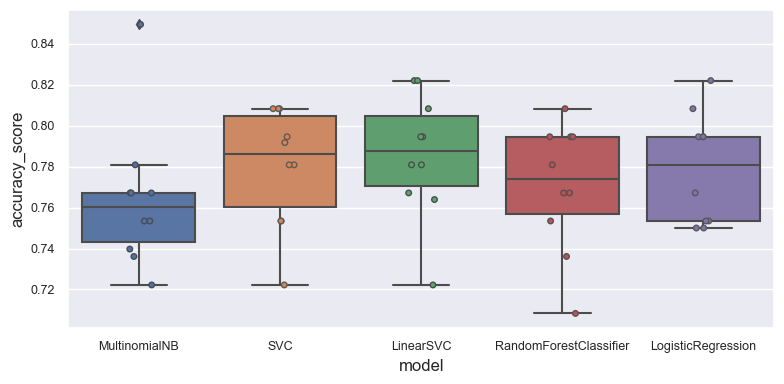

In [19]:
cv_results = get_cross_val_scores(models, X_train, y_train)

plt.figure(figsize=(8,4))

cs_metrics_bxplt = sns.boxplot(x='model', y='accuracy_score', data=cv_results)
cs_metrics_stplt = sns.stripplot(x='model', y='accuracy_score', hue='model', data=cv_results,
                                 size=4, jitter=True, linewidth=1, legend=False)

cs_metrics_bxplt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

In [20]:
cv_results.groupby('model').accuracy_score.mean()

model
LinearSVC                 0.785597
LogisticRegression        0.778767
MultinomialNB             0.763642
RandomForestClassifier    0.770472
SVC                       0.780156
Name: accuracy_score, dtype: float64

In [120]:
scores = []
metrics = ['accuracy', 'recall_macro', 'f1_macro']

for model in models:
    results = [model.__class__.__name__]
    for metric in metrics:
        results.append(cross_val_score(model, X_train, y_train, cv = 10, scoring = metric).mean())
    
    scores.append(results)
    model.fit(X_train, y_train)

mean_metrics = pd.DataFrame(scores, columns=['model', 'accuracy', 'recall_macro', 'f1_macro'])

D:\Distributions\Miniconda3\envs\science\lib\site-packages\sklearn\ensemble\_forest.py:453: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


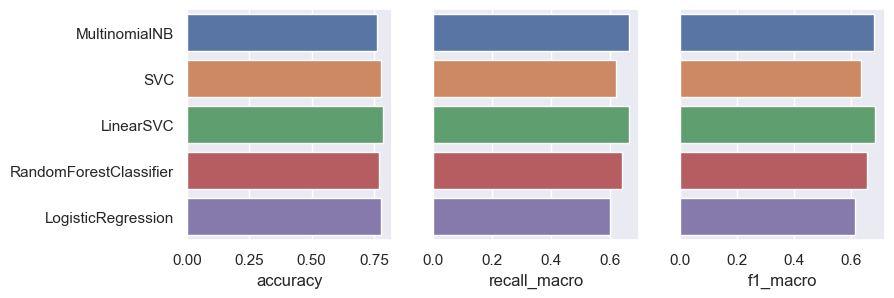

In [121]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

sns.barplot(data=mean_metrics, x='accuracy', y='model', orient='h', ax=axes[0])
sns.barplot(data=mean_metrics, x='recall_macro', y='model', orient='h', ax=axes[1])
sns.barplot(data=mean_metrics, x='f1_macro', y='model', orient='h', ax=axes[2])

axes[0].set(ylabel=None)
axes[1].set(ylabel=None)
axes[2].set(ylabel=None)

plt.show()

In [128]:
test_accuracies = []
for model in models:
    accuracies = cross_val_score(model, X_test, y_test, cv = 10, scoring = 'accuracy')

    for i, accuracy in enumerate(accuracies):
        test_accuracies.append((model.__class__.__name__, i, accuracy))

test_results = pd.DataFrame(measurements, columns=['model', 'fold', 'accuracy_score'])
test_results.groupby('model').accuracy_score.mean()

model
LinearSVC                 0.789137
LogisticRegression        0.808307
MultinomialNB             0.792332
RandomForestClassifier    0.792332
SVC                       0.798722
Name: accuracy_score, dtype: float64

In [ ]:
# NEW PREDICTION

'''
new_phrase = {
    'phrase': ["need to be good programming"],
    'type': [None]
}

new = pd.concat([df, pd.DataFrame(new_phrase)], axis=0).reset_index(drop=True)
print(new['phrase'].iloc[-1], '\n')

X = transformer.transform(new["phrase"])
print('TfIdf:\n', X[-1], '\n')

predictions = []
for model in models:
    predictions.append(model.score(X_test,  y_test))
    
print(predictions)
'''